<a href="https://colab.research.google.com/github/Balpier/-Predicci-n-de-Precios-de-Viviendas/blob/main/Proyecto_F2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<ipython-input-1-17868517c8dd>:52: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  X[col].fillna(X[col].mean(), inplace=True)


Mejores parámetros KNN: {'n_neighbors': 4, 'weights': 'distance'}
Mejor score CV (neg MSE): -3818031999.397771
Regresión Lineal: RMSE = 1075.65, R2 = 1.00
KNN Regressor Optimizado: RMSE = 47607.88, R2 = 0.98
SVR (Kernel RBF): RMSE = 340672.52, R2 = 0.00
Árbol de Regresión: RMSE = 4103.62, R2 = 1.00

=== Reporte detallado regresión ===

Modelo: Regresión Lineal
  - RMSE: 1075.6483
  - R²: 1.0000
----------------------------------------
Modelo: KNN Regressor Optimizado
  - RMSE: 47607.8778
  - R²: 0.9805
----------------------------------------
Modelo: SVR (Kernel RBF)
  - RMSE: 340672.5158
  - R²: 0.0034
----------------------------------------
Modelo: Árbol de Regresión
  - RMSE: 4103.6194
  - R²: 0.9999
----------------------------------------

=== Reporte tipo clasificación por rangos de precio ===

Reporte Regresión Lineal:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       580
           1       1.00      0.97      0.98        3

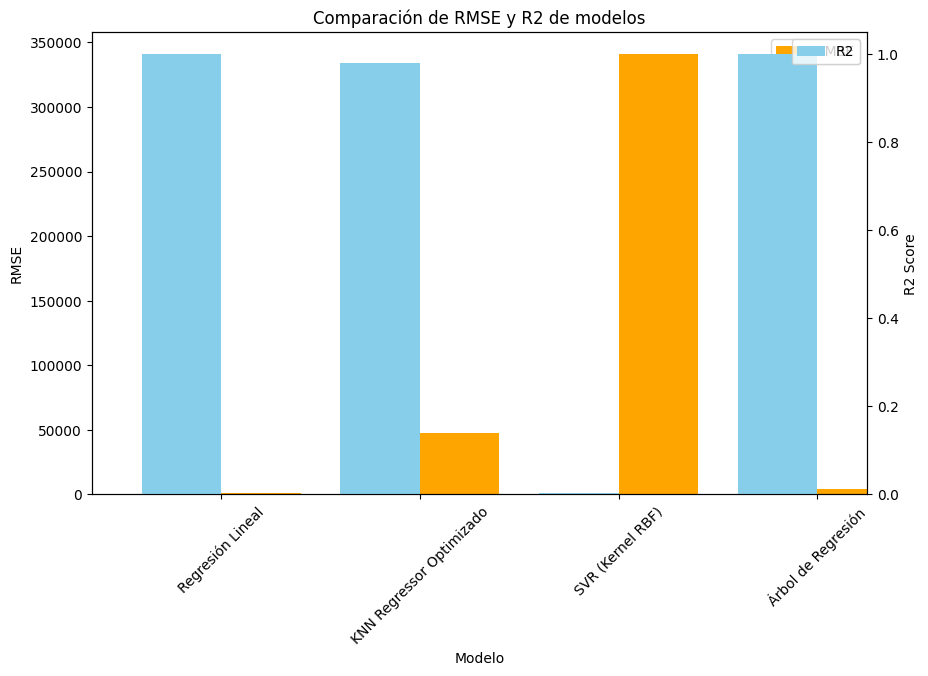

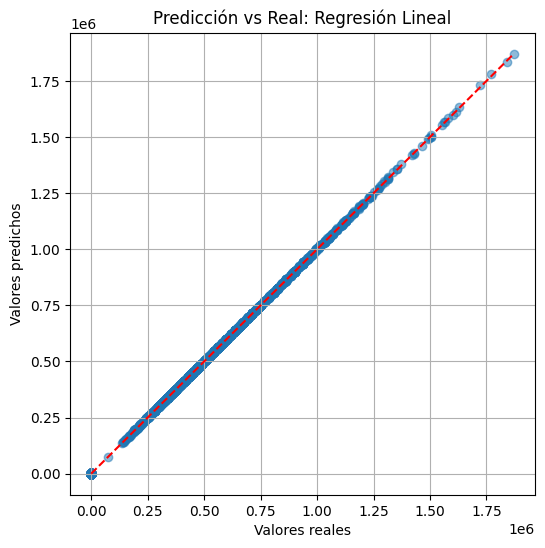

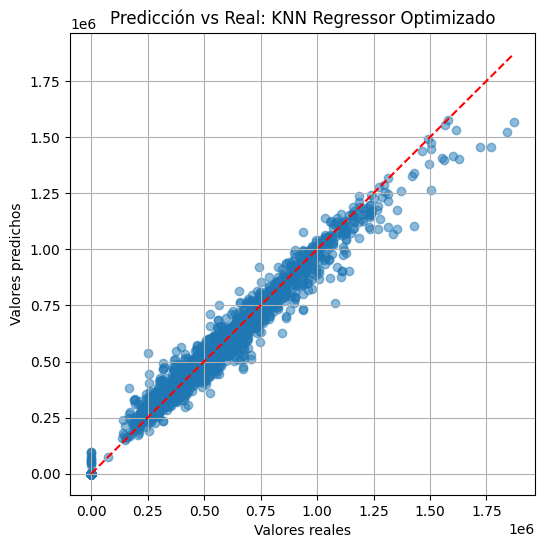

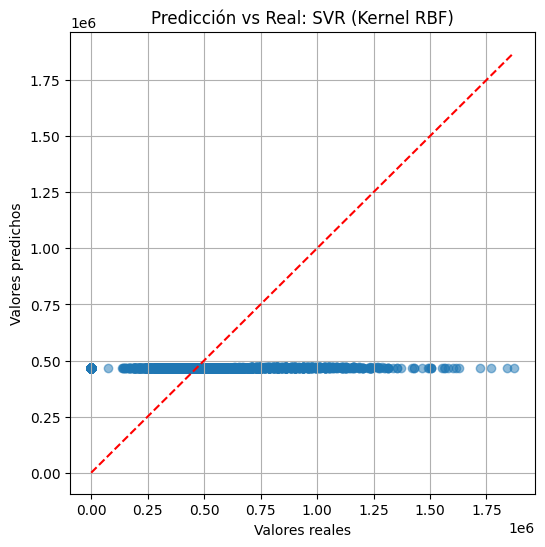

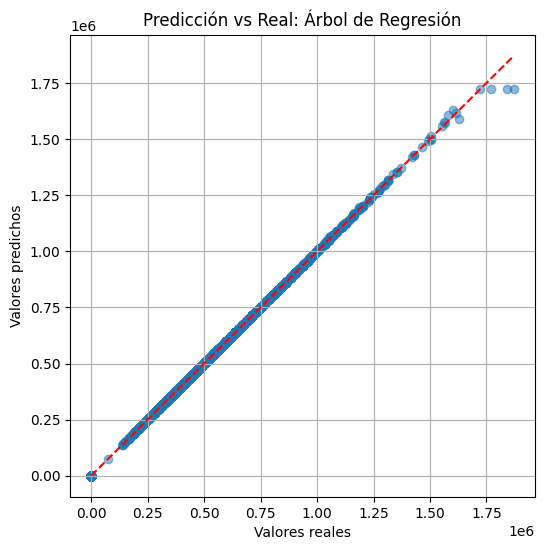

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, r2_score, classification_report
import matplotlib.pyplot as plt

# 1. Carga y limpieza
data = pd.read_csv('DatosViviendaPeru.csv', encoding='latin1', sep=';', on_bad_lines='skip')

# Normalizar nombres columnas
data.columns = data.columns.str.strip().str.lower().str.replace(' ', '_').str.replace('ó','o').str.replace('ú','u').str.replace('ñ','n')

cols_num_potenciales = [
    'precio_en_soles_corrientes',
    'precio_en_dolares_corrientes',
    'precio_en_soles_constantes_de_2009',
    'superficie',
    'numero_de_habitaciones',
    'numero_de_banos',
    'numero_de_garajes',
    'piso_de_ubicacion',
    'anos_de_antiguedad',
    'ipc',
    'tipo_de_cambio',
    'trimestre',
    'ano'
]

for col in cols_num_potenciales:
    if col in data.columns:
        data[col] = data[col].astype(str).str.replace(' ', '').str.replace(',', '.')
        data[col] = pd.to_numeric(data[col], errors='coerce')

target_col = 'precio_en_soles_corrientes'
data = data.dropna(subset=[target_col])

X = data.drop(columns=[target_col])
y = data[target_col]

# Codificar variable categórica
cat_col = 'distrito'
le = LabelEncoder()
X[cat_col] = le.fit_transform(X[cat_col].astype(str))

num_cols = X.select_dtypes(include=[np.number]).columns.tolist()
for col in num_cols:
    X[col].fillna(X[col].mean(), inplace=True)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train[num_cols] = scaler.fit_transform(X_train[num_cols])
X_test[num_cols] = scaler.transform(X_test[num_cols])

# Optimización KNN con GridSearchCV
param_grid_knn = {'n_neighbors': range(1, 21), 'weights': ['uniform', 'distance']}
grid_knn = GridSearchCV(KNeighborsRegressor(), param_grid_knn, cv=5, scoring='neg_mean_squared_error')
grid_knn.fit(X_train, y_train)
best_knn = grid_knn.best_estimator_

print("Mejores parámetros KNN:", grid_knn.best_params_)
print("Mejor score CV (neg MSE):", grid_knn.best_score_)

# Modelos a evaluar (incluyendo el KNN optimizado)
models = {
    'Regresión Lineal': LinearRegression(),
    'KNN Regressor Optimizado': best_knn,
    'SVR (Kernel RBF)': SVR(kernel='rbf'),
    'Árbol de Regresión': DecisionTreeRegressor(random_state=42)
}

results = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    results[name] = {'RMSE': rmse, 'R2': r2, 'y_pred': y_pred}
    print(f"{name}: RMSE = {rmse:.2f}, R2 = {r2:.2f}")

print("\n=== Reporte detallado regresión ===\n")
for name, metric in results.items():
    print(f"Modelo: {name}")
    print(f"  - RMSE: {metric['RMSE']:.4f}")
    print(f"  - R²: {metric['R2']:.4f}")
    print("-" * 40)

# Definir bins ampliados para evitar NaN en categorías
bins = [y.min() - 1, 100000, 200000, 300000, 400000, y.max() + 1]
labels = [0, 1, 2, 3, 4]

print("\n=== Reporte tipo clasificación por rangos de precio ===\n")

for name, metric in results.items():
    # Limpieza NaN en predicciones
    y_pred_clean = np.nan_to_num(metric['y_pred'], nan=np.nanmin(metric['y_pred']))

    y_true_cat = pd.cut(y_test, bins=bins, labels=labels, include_lowest=True)
    y_pred_cat = pd.cut(y_pred_clean, bins=bins, labels=labels, include_lowest=True)

    # Quitar NaN resultantes de pd.cut (si hay)
    mask = y_true_cat.notna() & y_pred_cat.notna()
    y_true_cat_clean = y_true_cat[mask]
    y_pred_cat_clean = y_pred_cat[mask]

    print(f"Reporte {name}:")
    print(classification_report(y_true_cat_clean, y_pred_cat_clean, zero_division=0))
    print("-" * 60)

# Gráficos métricas
df_metrics = pd.DataFrame({
    'Modelo': list(results.keys()),
    'RMSE': [v['RMSE'] for v in results.values()],
    'R2': [v['R2'] for v in results.values()]
})

fig, ax1 = plt.subplots(figsize=(10,6))
df_metrics.set_index('Modelo')['RMSE'].plot(kind='bar', ax=ax1, color='orange', position=0, width=0.4)
ax1.set_ylabel('RMSE')
ax1.set_title('Comparación de RMSE y R2 de modelos')
ax1.set_xticklabels(df_metrics['Modelo'], rotation=45)

ax2 = ax1.twinx()
df_metrics.set_index('Modelo')['R2'].plot(kind='bar', ax=ax2, color='skyblue', position=1, width=0.4)
ax2.set_ylabel('R2 Score')

ax1.legend(['RMSE'])
ax2.legend(['R2'], loc='upper right')
plt.show()

# Gráficos predicción vs real
for name, vals in results.items():
    plt.figure(figsize=(6,6))
    plt.scatter(y_test, vals['y_pred'], alpha=0.5)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
    plt.xlabel('Valores reales')
    plt.ylabel('Valores predichos')
    plt.title(f'Predicción vs Real: {name}')
    plt.grid(True)
    plt.show()


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# 1. Cargar datos
data = pd.read_csv('Datos_estandarizados_manual.csv', sep=',', encoding='latin1')

# 2. Normalizar nombres columnas
data.columns = data.columns.str.strip().str.lower().str.replace(' ', '_').str.replace('á','a').str.replace('í','i').str.replace('ó','o').str.replace('ú','u').str.replace('ñ','n')

# 3. Separar X e y
target_col = 'seguridad_zona'
X = data.drop(columns=[target_col])
y = data[target_col]

# 4. Codificar categóricas
cat_cols = X.select_dtypes(include=['object']).columns.tolist()
le = LabelEncoder()
for col in cat_cols:
    X[col] = le.fit_transform(X[col].astype(str))
if y.dtype == 'object':
    y = le.fit_transform(y.astype(str))

# 5. Imputar valores faltantes numéricos
num_cols = X.select_dtypes(include=[np.number]).columns.tolist()
for col in num_cols:
    X[col].fillna(X[col].mean(), inplace=True)

# 6. Dividir
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 7. Escalar numéricas
scaler = StandardScaler()
X_train[num_cols] = scaler.fit_transform(X_train[num_cols])
X_test[num_cols] = scaler.transform(X_test[num_cols])

# 8. Evaluar precisión KNN para K=1..20
k_values = range(1, 21)
accuracies = []
for k in k_values:
    model = KNeighborsClassifier(n_neighbors=k)
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    accuracies.append(accuracy_score(y_test, preds))

best_k = k_values[np.argmax(accuracies)]
best_acc = max(accuracies)
print(f"Mejor K: {best_k} con precisión: {best_acc:.4f}")

# Gráfico precisión vs K
plt.figure(figsize=(10,5))
plt.plot(k_values, accuracies, marker='o')
plt.title('Precisión KNN según número de vecinos (K)')
plt.xlabel('Número de Vecinos (K)')
plt.ylabel('Precisión')
plt.grid(True)
plt.show()

# 9. Entrenar y evaluar modelos con mejor K encontrado

# KNN mejor K
knn = KNeighborsClassifier(n_neighbors=best_k)
knn.fit(X_train, y_train)
y_pred_knn = knn.predict(X_test)
print(f"\nKNN (K={best_k}) precisión: {accuracy_score(y_test, y_pred_knn):.4f}")

# Regresión Logística
lr = LogisticRegression(max_iter=1000)
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)
print(f"Regresión Logística precisión: {accuracy_score(y_test, y_pred_lr):.4f}")

# SVM
svm = SVC(kernel='rbf')
svm.fit(X_train, y_train)
y_pred_svm = svm.predict(X_test)
print(f"SVM precisión: {accuracy_score(y_test, y_pred_svm):.4f}")

# Árbol de Decisión
dt = DecisionTreeClassifier(random_state=42)
dt.fit(X_train, y_train)
y_pred_dt = dt.predict(X_test)
print(f"Árbol de Decisión precisión: {accuracy_score(y_test, y_pred_dt):.4f}")

# 10. Reportes de clasificación
print("\nReporte KNN:\n", classification_report(y_test, y_pred_knn, zero_division=0))
print("\nReporte Regresión Logística:\n", classification_report(y_test, y_pred_lr, zero_division=0))
print("\nReporte SVM:\n", classification_report(y_test, y_pred_svm, zero_division=0))
print("\nReporte Árbol de Decisión:\n", classification_report(y_test, y_pred_dt, zero_division=0))

# 11. Graficar matrices de confusión
fig, axs = plt.subplots(2, 2, figsize=(12, 10))

ConfusionMatrixDisplay.from_estimator(knn, X_test, y_test, ax=axs[0,0], cmap='Blues')
axs[0,0].set_title('Matriz de Confusión KNN')

ConfusionMatrixDisplay.from_estimator(lr, X_test, y_test, ax=axs[0,1], cmap='Blues')
axs[0,1].set_title('Matriz de Confusión Regresión Logística')

ConfusionMatrixDisplay.from_estimator(svm, X_test, y_test, ax=axs[1,0], cmap='Blues')
axs[1,0].set_title('Matriz de Confusión SVM')

ConfusionMatrixDisplay.from_estimator(dt, X_test, y_test, ax=axs[1,1], cmap='Blues')
axs[1,1].set_title('Matriz de Confusión Árbol de Decisión')

plt.tight_layout()
plt.show()


<ipython-input-25-a866fb1f698b>:56: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  X[col].fillna(X[col].mean(), inplace=True)


Regresión Lineal: RMSE = 1075.65, R2 = 1.00
KNN Regressor: RMSE = 50967.87, R2 = 0.98
SVR (Kernel RBF): RMSE = 340672.52, R2 = 0.00
Árbol de Regresión: RMSE = 4103.62, R2 = 1.00

=== Reporte de desempeño de modelos de regresión ===

Modelo: Regresión Lineal
  - RMSE (Error cuadrático medio): 1075.6483
  - R² (Coeficiente de determinación): 1.0000
----------------------------------------
Modelo: KNN Regressor
  - RMSE (Error cuadrático medio): 50967.8696
  - R² (Coeficiente de determinación): 0.9777
----------------------------------------
Modelo: SVR (Kernel RBF)
  - RMSE (Error cuadrático medio): 340672.5158
  - R² (Coeficiente de determinación): 0.0034
----------------------------------------
Modelo: Árbol de Regresión
  - RMSE (Error cuadrático medio): 4103.6194
  - R² (Coeficiente de determinación): 0.9999
----------------------------------------

Reporte resumen de métricas:
               Modelo           RMSE        R2
0    Regresión Lineal    1075.648283  0.999990
1       KNN R

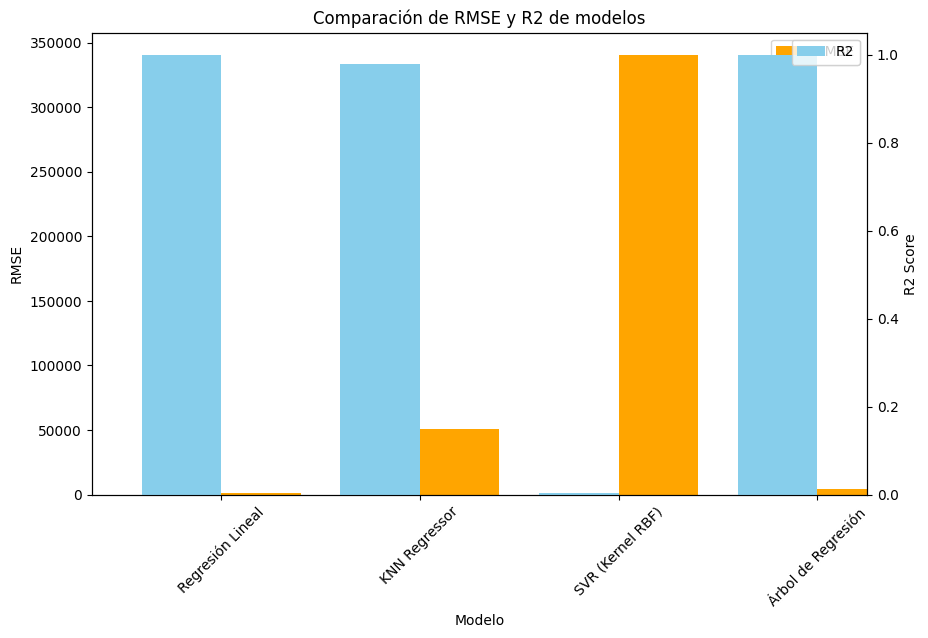

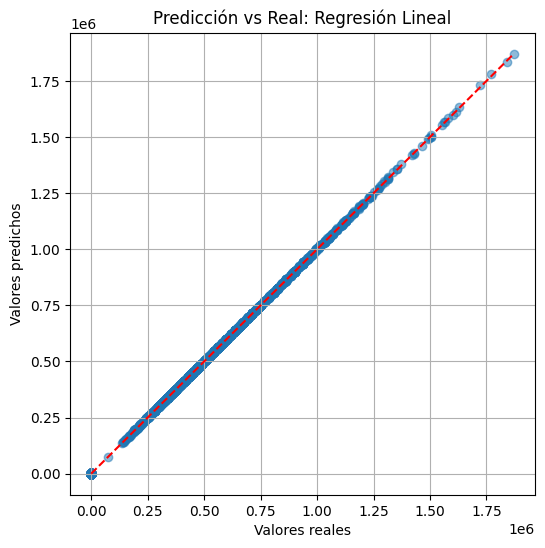

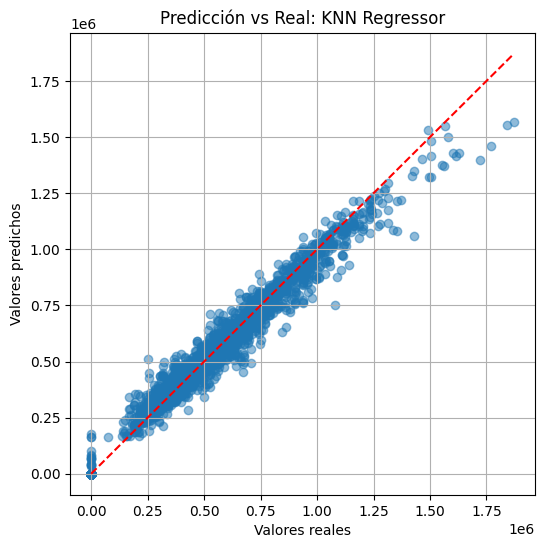

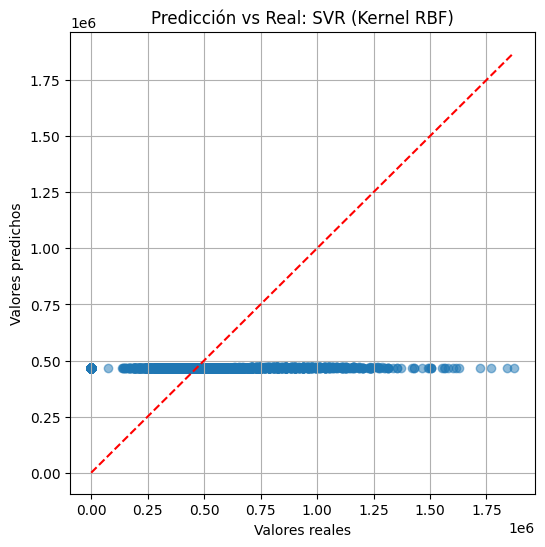

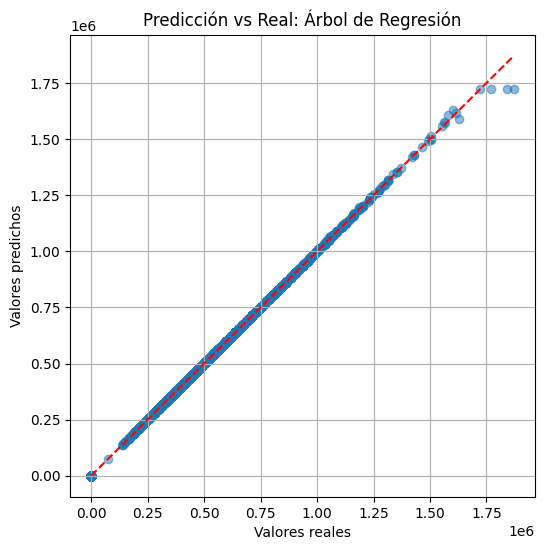

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

# 1. Carga de datos
data = pd.read_csv('DatosViviendaPeru.csv', encoding='latin1', sep=';', on_bad_lines='skip')  # Cambia el nombre según tu archivo

# 2. Normalizar nombres columnas
data.columns = data.columns.str.strip().str.lower().str.replace(' ', '_').str.replace('ó','o').str.replace('ú','u').str.replace('ñ','n')

# -- LIMPIEZA DE COLUMNAS NUMÉRICAS QUE PUEDAN TENER ESPACIOS --
cols_num_potenciales = [
    'precio_en_soles_corrientes',
    'precio_en_dolares_corrientes',
    'precio_en_soles_constantes_de_2009',
    'superficie',
    'numero_de_habitaciones',
    'numero_de_banos',
    'numero_de_garajes',
    'piso_de_ubicacion',
    'anos_de_antiguedad',
    'ipc',
    'tipo_de_cambio',
    'trimestre',
    'ano'
]

for col in cols_num_potenciales:
    if col in data.columns:
        data[col] = data[col].astype(str).str.replace(' ', '').str.replace(',', '.')
        data[col] = pd.to_numeric(data[col], errors='coerce')

# 3. Eliminar filas con NaN en variable objetivo
target_col = 'precio_en_soles_corrientes'  # Cambia según la variable que quieras predecir
data = data.dropna(subset=[target_col])

# 4. Separar características (X) y variable objetivo (y)
X = data.drop(columns=[target_col])
y = data[target_col]

# 5. Codificar la columna categórica (Distrito)
cat_col = 'distrito'
le = LabelEncoder()
X[cat_col] = le.fit_transform(X[cat_col].astype(str))

# 6. Imputar valores faltantes numéricos en X
num_cols = X.select_dtypes(include=[np.number]).columns.tolist()
for col in num_cols:
    X[col].fillna(X[col].mean(), inplace=True)

# 7. Dividir datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 8. Escalar columnas numéricas
scaler = StandardScaler()
X_train[num_cols] = scaler.fit_transform(X_train[num_cols])
X_test[num_cols] = scaler.transform(X_test[num_cols])

# 9. Definir modelos
models = {
    'Regresión Lineal': LinearRegression(),
    'KNN Regressor': KNeighborsRegressor(n_neighbors=5),
    'SVR (Kernel RBF)': SVR(kernel='rbf'),
    'Árbol de Regresión': DecisionTreeRegressor(random_state=42)
}

# 10. Entrenar, predecir y evaluar cada modelo
results = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    results[name] = {'RMSE': rmse, 'R2': r2, 'y_pred': y_pred}
    print(f"{name}: RMSE = {rmse:.2f}, R2 = {r2:.2f}")

# REPORTE DETALLADO
print("\n=== Reporte de desempeño de modelos de regresión ===\n")
for name, metric in results.items():
    print(f"Modelo: {name}")
    print(f"  - RMSE (Error cuadrático medio): {metric['RMSE']:.4f}")
    print(f"  - R² (Coeficiente de determinación): {metric['R2']:.4f}")
    print("-" * 40)

# REPORTE TABULADO
df_report = pd.DataFrame({
    'Modelo': list(results.keys()),
    'RMSE': [v['RMSE'] for v in results.values()],
    'R2': [v['R2'] for v in results.values()]
})

print("\nReporte resumen de métricas:")
print(df_report)

# 11. Gráficos comparativos de métricas
fig, ax1 = plt.subplots(figsize=(10,6))
df_report.set_index('Modelo')['RMSE'].plot(kind='bar', ax=ax1, color='orange', position=0, width=0.4)
ax1.set_ylabel('RMSE')
ax1.set_title('Comparación de RMSE y R2 de modelos')
ax1.set_xticklabels(df_report['Modelo'], rotation=45)

ax2 = ax1.twinx()
df_report.set_index('Modelo')['R2'].plot(kind='bar', ax=ax2, color='skyblue', position=1, width=0.4)
ax2.set_ylabel('R2 Score')

ax1.legend(['RMSE'])
ax2.legend(['R2'], loc='upper right')
plt.show()

# 12. Gráficos Predicción vs Real para cada modelo
for name, vals in results.items():
    plt.figure(figsize=(6,6))
    plt.scatter(y_test, vals['y_pred'], alpha=0.5)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
    plt.xlabel('Valores reales')
    plt.ylabel('Valores predichos')
    plt.title(f'Predicción vs Real: {name}')
    plt.grid(True)
    plt.show()


In [ ]:
import pandas as pd

data = pd.read_csv('DatosViviendaPeru.csv', encoding='latin1', sep =';',on_bad_lines='skip')

# Normalizar columnas
data.columns = data.columns.str.strip().str.lower().str.replace(' ', '_').str.replace('ó','o').str.replace('í','i')

print(data.columns.tolist())

target_col = 'precio_en_soles_corrientes'

X = data.drop(columns=[target_col])
y = data[target_col]

print(X.head())
print(y.head())


['ano', 'trimestre', 'precio_en_dolares_corrientes', 'tipo_de_cambio', 'ipc', 'precio_en_soles_corrientes', 'precio_en_soles_constantes_de_2009', 'distrito', 'superficie', 'numero_de_habitaciones', 'numero_de_banos', 'numero_de_garajes', 'piso_de_ubicacion', 'vista_al_exterior', 'anos_de_antiguedad']
    ano  trimestre precio_en_dolares_corrientes  tipo_de_cambio     ipc  \
0  2024          1                      122 981            3.76  162.44   
1  2024          1                       73 555            3.76  162.44   
2  2024          1                       65 161            3.76  162.44   
3  2024          1                       70 148            3.76  162.44   
4  2024          1                      105 058            3.76  162.44   

  precio_en_soles_constantes_de_2009     distrito  superficie  \
0                            284 614  Ate Vitarte          72   
1                            170 227  Ate Vitarte          88   
2                            150 801  Ate Vitarte   